<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Change Inputs Here

In [1]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 4 #768 512

# model_name = "gpt2-small"

save_files = True
run_on_other_tasks = True

# Setup

In [2]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [9]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [10]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Import functions from repo

In [11]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 875 (delta 187), reused 257 (delta 107), pack-reused 534
Receiving objects: 100% (875/875), 16.78 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (550/550), done.
/content/seqcont_circuits/src/iter_node_pruning


In [12]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# test utils prompts

In [13]:
example_prompt = "one two three"
example_answer = " four"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<s>', 'one', 'two', 'three']
Tokenized answer: ['', 'four']


Performance on answer token:
Rank: 5        Logit:  6.26 Prob:  0.99% Token: ||

Top 0th token. Logit: 10.45 Prob: 65.35% Token: |four|
Top 1th token. Logit:  8.04 Prob:  5.91% Token: |<0x0A>|
Top 2th token. Logit:  7.40 Prob:  3.09% Token: |...|
Top 3th token. Logit:  7.26 Prob:  2.71% Token: |go|
Top 4th token. Logit:  6.35 Prob:  1.08% Token: |!|
Top 5th token. Logit:  6.26 Prob:  0.99% Token: ||
Top 6th token. Logit:  6.10 Prob:  0.85% Token: |,|
Top 7th token. Logit:  5.98 Prob:  0.75% Token: |by|
Top 8th token. Logit:  5.83 Prob:  0.64% Token: |five|
Top 9th token. Logit:  5.78 Prob:  0.61% Token: |.|


Performance on answer token:
Rank: 1        Logit:  8.82 Prob: 13.93% Token: |four|

Top 0th token. Logit:  9.41 Prob: 24.94% Token: |4|
Top 1th token. Logit:  8.82 Prob: 13.93% Token: |four|
Top 2th token. Logit:  8.71 Prob: 12.43% Token: |<0x0A>|
Top 3th token. Logit:  7.88 Prob:  5.40% Token: |<0xF0>|
Top 4th token. Logit:  7.83 Prob:  5.16% Token: |1|
Top 5th token. Logit:  6.53 Prob:  1.41% Token: |0|
Top 6th token. Logit:  6.48 Prob:  1.34% Token: |5|
Top 7th token. Logit:  6.43 Prob:  1.28% Token: |Four|
Top 8th token. Logit:  6.27 Prob:  1.08% Token: |2|
Top 9th token. Logit:  6.08 Prob:  0.90% Token: |by|


Ranks of the answer tokens: [('', 5), ('four', 1)]

In [14]:
example_prompt = "one two three four"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<s>', 'one', 'two', 'three', 'four']
Tokenized answer: ['', 'five']


Performance on answer token:
Rank: 18       Logit:  8.98 Prob:  0.06% Token: ||

Top 0th token. Logit: 16.25 Prob: 90.30% Token: |five|
Top 1th token. Logit: 13.01 Prob:  3.51% Token: |<0x0A>|
Top 2th token. Logit: 10.77 Prob:  0.37% Token: |!|
Top 3th token. Logit: 10.72 Prob:  0.36% Token: |.|
Top 4th token. Logit: 10.52 Prob:  0.29% Token: |...|
Top 5th token. Logit: 10.34 Prob:  0.24% Token: |five|
Top 6th token. Logit: 10.12 Prob:  0.19% Token: |four|
Top 7th token. Logit: 10.05 Prob:  0.18% Token: |,|
Top 8th token. Logit:  9.97 Prob:  0.17% Token: |(|
Top 9th token. Logit:  9.92 Prob:  0.16% Token: |</s>|


Performance on answer token:
Rank: 0        Logit: 10.45 Prob: 32.73% Token: |five|

Top 0th token. Logit: 10.45 Prob: 32.73% Token: |five|
Top 1th token. Logit:  9.69 Prob: 15.31% Token: |<0x0A>|
Top 2th token. Logit:  9.67 Prob: 14.93% Token: |5|
Top 3th token. Logit:  8.86 Prob:  6.69% Token: |<0xF0>|
Top 4th token. Logit:  7.93 Prob:  2.63% Token: |................|
Top 5th token. Logit:  7.25 Prob:  1.33% Token: |Five|
Top 6th token. Logit:  7.11 Prob:  1.15% Token: |.|
Top 7th token. Logit:  7.05 Prob:  1.09% Token: |five|
Top 8th token. Logit:  6.92 Prob:  0.96% Token: |1|
Top 9th token. Logit:  6.32 Prob:  0.53% Token: |I|


Ranks of the answer tokens: [('', 18), ('five', 0)]

# Generate dataset with multiple prompts

In [28]:
class Dataset:
    def __init__(self, prompts, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        pos_dict = {}
        # for i in range(1, 4):
        #     pos_dict['S'+str(i)] = i
        list_tokens = tokenizer.tokenize('2 4 6 ')
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [29]:
words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']

def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            # 'corr': str(i+4),
            # 'incorr': str(i+3),
            # 'text': f"{i} {i+1} {i+2}"
            'corr': ' '+words[i+4],
            'incorr': ' '+words[i+3],  # this is arbitrary
            'text': f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
        }
        list_tokens = tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            prompt_dict['S'+str(i)] = tok_as_str
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(0, 8)
prompts_list

[{'corr': ' five',
  'incorr': ' four',
  'text': 'one two three four',
  'S0': '▁one',
  'S1': '▁two',
  'S2': '▁three',
  'S3': '▁four'},
 {'corr': ' six',
  'incorr': ' five',
  'text': 'two three four five',
  'S0': '▁two',
  'S1': '▁three',
  'S2': '▁four',
  'S3': '▁five'},
 {'corr': ' seven',
  'incorr': ' six',
  'text': 'three four five six',
  'S0': '▁three',
  'S1': '▁four',
  'S2': '▁five',
  'S3': '▁six'},
 {'corr': ' eight',
  'incorr': ' seven',
  'text': 'four five six seven',
  'S0': '▁four',
  'S1': '▁five',
  'S2': '▁six',
  'S3': '▁seven'},
 {'corr': ' nine',
  'incorr': ' eight',
  'text': 'five six seven eight',
  'S0': '▁five',
  'S1': '▁six',
  'S2': '▁seven',
  'S3': '▁eight'},
 {'corr': ' ten',
  'incorr': ' nine',
  'text': 'six seven eight nine',
  'S0': '▁six',
  'S1': '▁seven',
  'S2': '▁eight',
  'S3': '▁nine'},
 {'corr': ' eleven',
  'incorr': ' ten',
  'text': 'seven eight nine ten',
  'S0': '▁seven',
  'S1': '▁eight',
  'S2': '▁nine',
  'S3': '▁ten'},


In [30]:
import random

def generate_prompts_list_corr(prompt_list):
    words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']

    outlist = []
    for prompt_dict in prompts_list:
        r1 = random.choice(words)
        r2 = random.choice(words)
        while True:
            r3_ind = random.randint(0,len(words)-1)
            r4_ind = random.randint(0,len(words)-1)
            if words[r3_ind] != words[r4_ind-1]:
                break
        r3 = words[r3_ind]
        r4 = words[r4_ind]

        new_prompt_dict = {
            'corr': prompt_dict['corr'],
            'incorr': prompt_dict['incorr'],
            'text': f"{r1} {r2} {r3} {r4}"
        }
        list_tokens = tokenizer.tokenize(new_prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            new_prompt_dict['S'+str(i)] = tok_as_str
        outlist.append(new_prompt_dict)
    return outlist

prompts_list_2 = generate_prompts_list_corr(prompts_list)
prompts_list_2

[{'corr': ' five',
  'incorr': ' four',
  'text': 'seven two one ten',
  'S0': '▁seven',
  'S1': '▁two',
  'S2': '▁one',
  'S3': '▁ten'},
 {'corr': ' six',
  'incorr': ' five',
  'text': 'nine two four four',
  'S0': '▁nine',
  'S1': '▁two',
  'S2': '▁four',
  'S3': '▁four'},
 {'corr': ' seven',
  'incorr': ' six',
  'text': 'five three nine three',
  'S0': '▁five',
  'S1': '▁three',
  'S2': '▁nine',
  'S3': '▁three'},
 {'corr': ' eight',
  'incorr': ' seven',
  'text': 'four two two eleven',
  'S0': '▁four',
  'S1': '▁two',
  'S2': '▁two',
  'S3': '▁eleven'},
 {'corr': ' nine',
  'incorr': ' eight',
  'text': 'one eight eleven one',
  'S0': '▁one',
  'S1': '▁eight',
  'S2': '▁eleven',
  'S3': '▁one'},
 {'corr': ' ten',
  'incorr': ' nine',
  'text': 'seven eight two four',
  'S0': '▁seven',
  'S1': '▁eight',
  'S2': '▁two',
  'S3': '▁four'},
 {'corr': ' eleven',
  'incorr': ' ten',
  'text': 'six four one nine',
  'S0': '▁six',
  'S1': '▁four',
  'S2': '▁one',
  'S3': '▁nine'},
 {'cor

In [31]:
dataset = Dataset(prompts_list, model.tokenizer)
dataset_2 = Dataset(prompts_list_2, model.tokenizer)

# Get orig score

In [32]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [33]:
next_token = logits_original[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'five'


In [34]:
orig_score

tensor(-4.9034, device='cuda:0')

In [35]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

41

# ablation fns mult tok answers

In [ ]:
def clean_gen(model, clean_text, corr_ans):
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    tokens = model.to_tokens(clean_text).to(device)
    # tokens = tokens[:, 1:] # get rid of prepend bos when using model.to_tokens

    total_score = 0
    corr_ans_tokLen = 0
    ans_so_far = ''
    # while True:
    for i in range(5):
        print(f"Sequence so far: {model.to_string(tokens)[0]!r}")
        logits = model(tokens)
        next_token = logits[0, -1].argmax(dim=-1) # Get the predicted token at the end of our sequence
        next_char = model.to_string(next_token)
        if next_char == '':
            next_char = ' '

        correct_logits = logits[:, -1, next_token]
        total_score += correct_logits
        # print(f"logit of new tok: {correct_logits}")

        ans_so_far += next_char
        corr_ans_tokLen += 1
        print(f"{tokens.shape[-1]+1}th char = {next_char!r}")
        if ans_so_far == corr_ans:
            print('\nTotal logits: ', total_score.item())
            break

        # Define new input sequence, by appending the previously generated token
        tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
        # clean_text = clean_text + next_char
        # tokens = model.to_tokens(clean_text).to(device)
    return corr_ans_tokLen, total_score.item()

In [ ]:
def ablate_then_gen(model, clean_text, corr_text, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen):
    tokens = model.to_tokens(clean_text).to(device)
    prompts_list = generate_prompts_list_longer(clean_text, tokens)

    corr_tokens = model.to_tokens(corr_text).to(device)
    prompts_list_2 = generate_prompts_list_longer(corr_text, corr_tokens)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    pos_dict = {}
    # for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
    num_pos = len(model.tokenizer(prompts_list_2[0]['text']).input_ids)
    # for i in range(num_pos + 1):
    for i in range(num_pos ):
        pos_dict['S'+str(i)] = i
    dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)
    # dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, tokens)
    # pdb.set_trace()
    model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

    # tokens = tokens[:, 1:] # get rid of prepend bos when using model.to_tokens
    logits = model(tokens)
    next_token = logits[0, -1].argmax(dim=-1)
    next_char = model.to_string(next_token)

    total_score = 0

    for i in range(corr_ans_tokLen):
    # for i in range(5):
        if next_char == '':
            next_char = ' '

        clean_text = clean_text + next_char
        # tokens = model.to_tokens(clean_text).to(device)
        # tokens = tokens[:, 1:]
        print(f"Sequence so far: {clean_text}")
        print(f"{tokens.shape[-1]+1}th char = {next_char!r}")

        # clean_text = model.to_string(tokens)[0]
        tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
        # print(clean_text)
        # print(tokens.shape)

        # get new ablation dataset
        # model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

        # corr_text = corr_text + next_char
        # # corr_tokens = model.to_tokens(corr_text).to(device)

        # # corr_text = model.to_string(corr_tokens)[0]
        # corr_tokens = torch.cat([corr_tokens, next_token[None, None]], dim=-1)
        # prompts_list_2 = generate_prompts_list_longer(corr_text, corr_tokens)
        # print(corr_text)
        # # print(corr_tokens.shape)

        # pos_dict = {}
        # # for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        # # for i in range(corr_tokens.shape[1]):
        # num_pos = len(model.tokenizer(prompts_list_2[0]['text']).input_ids)
        # # for i in range(num_pos + 1):
        # for i in range(num_pos ):
        #     pos_dict['S'+str(i)] = i

        # # dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)
        # dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, corr_tokens)

        # model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

        logits = model(tokens)
        next_token = logits[0, -1].argmax(dim=-1) # Get the predicted token at the end of our sequence
        next_char = model.to_string(next_token)

        # new_score = get_logit_diff(logits, dataset)
        corrTok_logits = logits[:, -1, next_token]
        total_score += corrTok_logits
        # print(f"corr logit of new char: {corrTok_logits}")
    print('\nTotal corr logit: ', total_score.item())
    return total_score.item()

# test clean run

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [45]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}

list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
for i, tok_as_str in enumerate(list_tokens):
    CIRCUIT['S'+str(i)] = lst
    if i == len(list_tokens) - 1:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
    else:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0', 'S1': 'S1', 'S2': 'S2', 'S3': 'end'}

In [46]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

# clean_text = "12 14 16"
# corr_text = "15 12 17"
# heads_not_ablate = []  # ablate all heads but not MLPs
# mlps_not_ablate = []  # ablate all MLPs
# # ablated_score = ablate_then_gen(model, clean_text, corr_text, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen)

# ablated_score = ablate_then_gen(model, dataset.toks, dataset_2.toks, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen)

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
logits_minimal = model(dataset.toks)

new_score = get_logit_diff(logits_minimal, dataset)

In [47]:
next_token = logits_minimal[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'five'


In [48]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(-4.9034, device='cuda:0')

In [49]:
import gc

del(logits_minimal)
torch.cuda.empty_cache()
gc.collect()

0

## run each

In [51]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        if i == len(list_tokens) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [ ]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

## plot heatmap

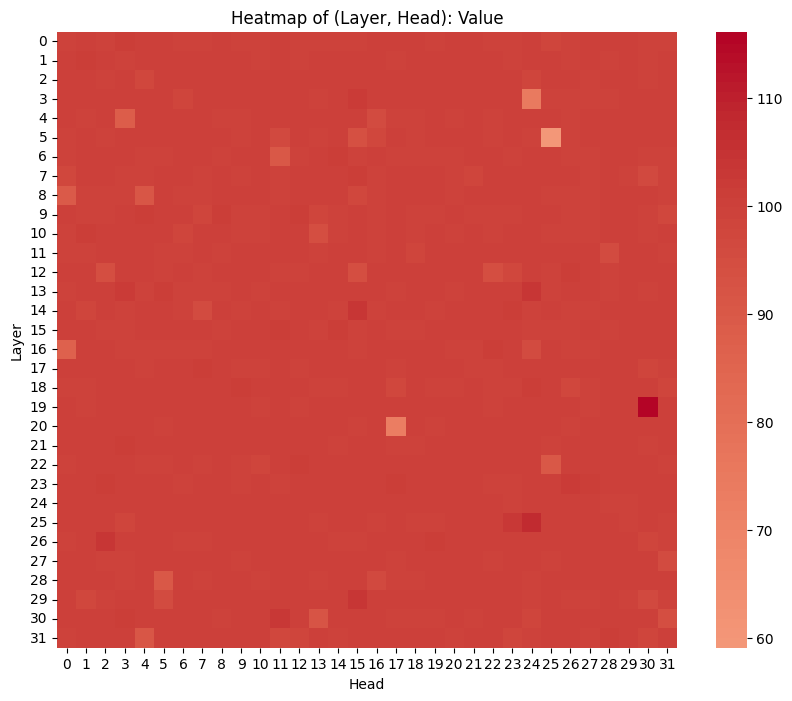

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dictionary to a DataFrame
data_list = [(key[0], key[1], value) for key, value in lh_scores.items()]
df = pd.DataFrame(data_list, columns=['Layer', 'Head', 'Value'])

# Create a pivot table
pivot_table = df.pivot(index='Layer', columns='Head', values='Value').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Heatmap of (Layer, Head): Value')

# Rotate y-axis numbers to horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 68.39082336425781
1 60.9903564453125
2 67.35907745361328
3 76.4286880493164
4 74.830078125
5 83.50626373291016
6 76.4582290649414
7 73.5766372680664
8 94.43434143066406
9 101.66463470458984
10 82.34976196289062
11 100.44725036621094
12 107.74789428710938
13 106.05551147460938
14 103.30465698242188
15 76.74903106689453
16 93.27847290039062
17 100.48667907714844
18 88.48347473144531
19 93.16832733154297
20 87.30072784423828
21 97.45310974121094
22 96.55979919433594
23 99.94934844970703
24 94.39239501953125
25 103.35821533203125
26 99.5173110961914
27 92.53862762451172
28 87.70771026611328
29 85.92241668701172
30 104.64595031738281
31 72.6233139038086


# Node Ablation Iteration

## new fns

In [53]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circuit_backw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(32) for head in range(32)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(32)]

    comp_scores = {}
    for layer in range(31, -1, -1):  # go thru all heads in a layer first
        print(layer)
        if layer in mlps_not_ablate:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        for head in range(32):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [54]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [55]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

31
(cand circuit / full) %: 98.4337
Removed: MLP  31
31 0
(cand circuit / full) %: 98.4481
Removed: (31, 0)
31 1
(cand circuit / full) %: 98.4270
Removed: (31, 1)
31 2
(cand circuit / full) %: 98.4091
Removed: (31, 2)
31 3
(cand circuit / full) %: 98.3589
Removed: (31, 3)
31 4
(cand circuit / full) %: 98.4208
Removed: (31, 4)
31 5
(cand circuit / full) %: 98.0800
Removed: (31, 5)
31 6
(cand circuit / full) %: 98.0815
Removed: (31, 6)
31 7
(cand circuit / full) %: 98.0523
Removed: (31, 7)
31 8
(cand circuit / full) %: 97.8069
Removed: (31, 8)
31 9
(cand circuit / full) %: 97.8058
Removed: (31, 9)
31 10
(cand circuit / full) %: 99.8176
Removed: (31, 10)
31 11
(cand circuit / full) %: 99.7463
Removed: (31, 11)
31 12
(cand circuit / full) %: 99.7771
Removed: (31, 12)
31 13
(cand circuit / full) %: 99.8402
Removed: (31, 13)
31 14
(cand circuit / full) %: 99.7329
Removed: (31, 14)
31 15
(cand circuit / full) %: 99.3047
Removed: (31, 15)
31 16
(cand circuit / full) %: 99.2895
Removed: (31, 16

In [62]:
with open('numwords_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numwords_b_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
curr_circ_heads

[(0, 1),
 (0, 4),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (1, 16),
 (1, 24),
 (1, 27),
 (1, 28),
 (2, 2),
 (2, 5),
 (2, 8),
 (2, 24),
 (2, 30),
 (3, 7),
 (3, 14),
 (3, 19),
 (3, 23),
 (4, 3),
 (5, 16),
 (5, 25),
 (6, 11),
 (6, 14),
 (7, 0),
 (7, 30),
 (8, 0),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 6),
 (8, 21),
 (8, 31),
 (9, 1),
 (9, 3),
 (9, 7),
 (9, 11),
 (9, 29),
 (9, 31),
 (10, 13),
 (10, 18),
 (10, 23),
 (10, 24),
 (10, 25),
 (10, 27),
 (11, 18),
 (11, 28),
 (12, 18),
 (12, 26),
 (13, 11),
 (13, 17),
 (13, 18),
 (13, 19),
 (13, 20),
 (13, 21),
 (13, 23),
 (14, 7),
 (14, 14),
 (15, 25),
 (15, 28),
 (16, 0),
 (16, 12),
 (16, 14),
 (16, 15),
 (16, 16),
 (16, 19),
 (16, 24),
 (16, 29),
 (17, 17),
 (17, 23),
 (17, 31),
 (18, 31),
 (19, 12),
 (20, 17),
 (27, 20),
 (27, 25),
 (27, 27),
 (27, 31),
 (28, 5),
 (29, 5)]

In [58]:
curr_circ_mlps

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 22,
 24,
 26,
 27]

## Find most impt heads from circ

In [59]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 80.4824


In [60]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 80.2448
removed: (0, 4)
(cand circuit / full) %: 79.4644
removed: (0, 6)
(cand circuit / full) %: 80.4124
removed: (0, 7)
(cand circuit / full) %: 80.5808
removed: (0, 8)
(cand circuit / full) %: 80.3096
removed: (0, 10)
(cand circuit / full) %: 80.3459
removed: (0, 11)
(cand circuit / full) %: 80.3378
removed: (0, 12)
(cand circuit / full) %: 80.3145
removed: (1, 16)
(cand circuit / full) %: 79.6085
removed: (1, 24)
(cand circuit / full) %: 79.9609
removed: (1, 27)
(cand circuit / full) %: 79.0311
removed: (1, 28)
(cand circuit / full) %: 80.3254
removed: (2, 2)
(cand circuit / full) %: 79.4710
removed: (2, 5)
(cand circuit / full) %: 79.9562
removed: (2, 8)
(cand circuit / full) %: 79.9953
removed: (2, 24)
(cand circuit / full) %: 79.7058
removed: (2, 30)
(cand circuit / full) %: 79.9280
removed: (3, 7)
(cand circuit / full) %: 77.7914
removed: (3, 14)
(cand circuit / full) %: 80.1138
removed: (3, 19)
(cand circuit / full) %: 71.6349
removed: 

In [61]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(20, 17) -40.03
(5, 25) -21.32
(16, 0) -14.18
(29, 5) -13.2
(3, 19) -8.85
(6, 11) -8.81
(15, 25) -7.75
(8, 0) -6.73
(16, 24) -5.79
(8, 4) -5.43
(7, 0) -3.93
(6, 14) -3.9
(16, 29) -3.39
(5, 16) -3.05
(12, 26) -2.95
(4, 3) -2.8
(3, 7) -2.69
(7, 30) -2.31
(11, 28) -2.21
(28, 5) -2.1
(17, 31) -1.88
(13, 11) -1.66
(13, 20) -1.64
(12, 18) -1.53
(1, 27) -1.45
(10, 13) -1.3
(18, 31) -1.29
(8, 6) -1.22
(9, 1) -1.11
(0, 4) -1.02
(2, 2) -1.01
(9, 11) -0.98
(19, 12) -0.88
(1, 16) -0.87
(13, 17) -0.82
(9, 7) -0.82
(11, 18) -0.81
(2, 24) -0.78
(10, 18) -0.66
(9, 31) -0.62
(9, 29) -0.58
(2, 30) -0.55
(2, 5) -0.53
(1, 24) -0.52
(2, 8) -0.49
(15, 28) -0.46
(27, 31) -0.43
(16, 14) -0.42
(3, 23) -0.39
(3, 14) -0.37
(10, 23) -0.36
(27, 20) -0.35
(8, 3) -0.32
(14, 7) -0.29
(14, 14) -0.27
(16, 15) -0.27
(8, 2) -0.26
(17, 17) -0.24
(0, 1) -0.24
(10, 27) -0.2
(16, 19) -0.19
(0, 8) -0.17
(0, 12) -0.17
(1, 28) -0.16
(0, 11) -0.14
(17, 23) -0.14
(0, 10) -0.14
(0, 6) -0.07
(13, 19) -0.05
(8, 31) -0.03
(10, 24) -0

# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
